# ビート位置推定モデルの損失関数テクニック

深層ニューラルネットに基づくビート位置推定モデルは、入力した音響特徴から各フレームの「ビート確率」を推定することで、ビート位置を特定します。

ニューラルネットは、ビート・ダウンビート位置を示す正解ラベルと出力を近付けるように学習させるのが一般的です。

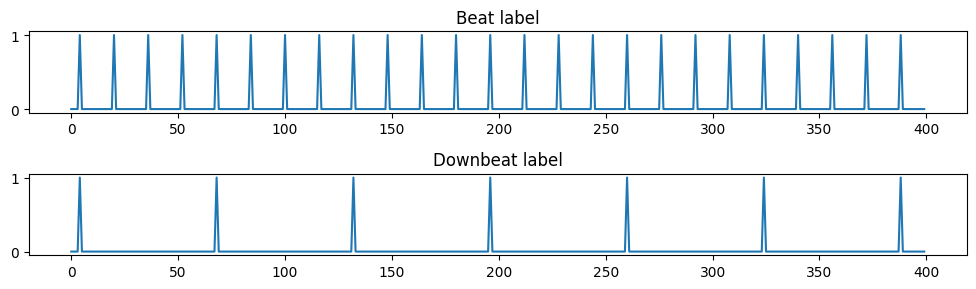

In [15]:
import numpy as np
import matplotlib.pyplot as plt

label_beat = np.zeros(400)
label_beat[4::16] = 1
label_downbeat = np.zeros(400)
label_downbeat[4::64] = 1

plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(label_beat)
plt.title('Beat label')
plt.subplot(2, 1, 2)
plt.plot(label_downbeat)
plt.title('Downbeat label')
plt.tight_layout()

上記の正解ラベルは、大半の値が0である不均衡なラベルであり、工夫無しにモデルを学習させると収束が遅くなったり、最悪ビート位置を全く推定できなくなります。既存のビート推定手法では、これらの問題を避けるためのテクニックが使われています。

## Target widening

正解ラベルのビート地点の隣接フレームにも0.5くらいの値を与え、正解ラベルを若干「ぼやけ」させる手法です。ラベル不均衡は緩和されますが、代償として推定結果も曖昧になります。

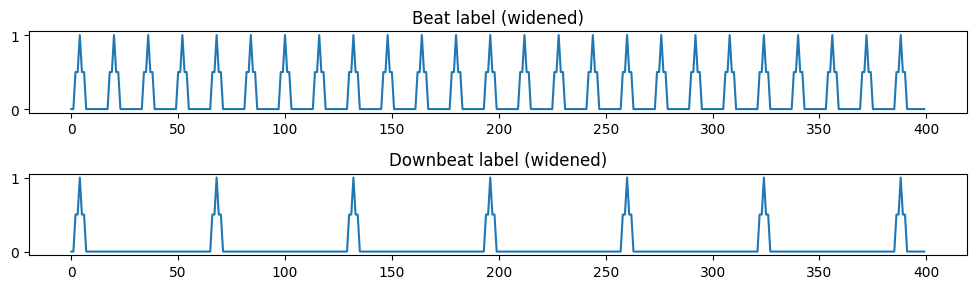

In [16]:
from scipy.ndimage import maximum_filter1d

def widen_label(t, size=5, value=0.5):
    return np.maximum(t, maximum_filter1d(t, size=size)*value)

label_beat_wide = widen_label(label_beat)
label_downbeat_wide = widen_label(label_downbeat)

plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(label_beat_wide)
plt.title('Beat label (widened)')
plt.subplot(2, 1, 2)
plt.plot(label_downbeat_wide)
plt.title('Downbeat label (widened)')
plt.tight_layout()


## Weighted binary cross entropy loss

ラベル不均衡緩和の定番テクニック、損失の重み付けです。ビート位置に大きい重みを付与します。

重みの値は定数を与えてもいいし、ビート位置の頻度によって動的に決めるのもアリです。

In [17]:
import torch

x_beat = torch.randn(1, 400)
t_beat = torch.tensor(label_beat_wide).view(1, 400)

weight = torch.ones_like(t_beat)
weight[t_beat == 1] = 100   # ビート位置に重み100を付ける
bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(x_beat, t_beat, weight=weight)

## Dice loss / Focal loss

こちらもラベル不均衡問題を緩和するために考案された損失関数です [^chen2022]。

[^chen2022]: Tsung-Ping Chen and Li Su, Toward postprocessing-free neural networks for joint beat and downbeat estimation, in Proceedings of the 23th International Society for Music Information Retrieval Conference (ISMIR), 2022. https://ismir2022program.ismir.net/poster_46.html

In [18]:
class Dice_loss(torch.nn.Module):
    def __init__(self):
        super(Dice_loss, self).__init__()

    def forward(self, y_pred, y_true):
        smooth = 1e-6
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true)
        return 1 - (2. * intersection + smooth) / (union + smooth)
    
class Focal_loss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(Focal_loss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        eps = 1e-6
        y_pred = torch.clamp(y_pred, eps, 1-eps)
        loss = -self.alpha * y_true * (1-y_pred)**self.gamma * torch.log(y_pred) - \
               (1-self.alpha) * (1-y_true) * y_pred**self.gamma * torch.log(1-y_pred)
        return torch.mean(loss)
    
dice_loss = Dice_loss()(torch.sigmoid(x_beat), t_beat)
focal_loss = Focal_loss()(torch.sigmoid(x_beat), t_beat)



## Shift-torelant BCE

人手で作成した正解ラベルが、「真のビート位置」から少しズレることはどうしても免れません。ビート推定モデルを鍛える過程でこうしたズレが蓄積すると、曖昧な推定結果を出力するようになってしまいます。損失計算時に時間方向のMax poolingを挟むことで、このようなズレに頑健な損失関数を作ることができます [^foscarin2024]。

[^foscarin2024]: Francesco Foscarin and Jan Schluter and Gerhard Widmer, Beat this! Accurate beat tracking without DBN postprocessing, in Proceedings of the 25th International Society for Music Information Retrieval Conference (ISMIR), 2024. https://ismir2024program.ismir.net/poster_10.html

In [19]:
class ShiftTorelantBCELoss(torch.nn.Module):
    def __init__(self, pos_weight=1, tolerance=3):
        super().__init__()
        self.register_buffer("pos_weight", torch.tensor(pos_weight, dtype=torch.get_default_dtype()), persistent=False)
        self.tolerance  = tolerance

    def spread(self, x: torch.Tensor, factor: int = 1):
        if self.tolerance == 0:
            return x
        return torch.nn.functional.max_pool1d(x, 1 + 2 * factor * self.tolerance, 1)
    def crop(self, x: torch.Tensor, factor: int = 1):
        return x[..., factor * self.tolerance : -factor * self.tolerance or None]
    def forward(
        self,
        preds: torch.Tensor,
        targets: torch.Tensor,
    ):
        # predsにmax poolingを適用し、targetとサイズを合わせる
        spreaded_preds = self.crop(self.spread(preds))
        cropped_targets = self.crop(targets, factor=2)
        # 正解ビート位置周辺の損失を無視する（重み=0）
        look_at = cropped_targets + (1 - self.spread(targets, factor=2))
        # BCE損失を計算
        return torch.nn.functional.binary_cross_entropy_with_logits(
            spreaded_preds,
            cropped_targets,
            weight=look_at,
            pos_weight=self.pos_weight,
        )

shift_torelant_bce_loss = ShiftTorelantBCELoss(pos_weight=100, tolerance=3)(x_beat, t_beat)